In [1]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import scipy as sp 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from data_loader import ACSEmploymentDataset
from folk_utils import format_params, initialize_base_model, set_protected_groups_by_input, set_protected_groups_config, intialize_splits_with_cluster_labels, predict_with_subdomain_model


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
#! brew install lightgbm

In [3]:
#! pip install --upgrade threadpoolctl

In [4]:
folktables_state = 'GA'
folktables_year = 2018

seed_lst = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_clusters_lst = [1, 2, 3, 4, 5, 6, 7, 8]

In [5]:
folk = ACSEmploymentDataset(state=[folktables_state], year=folktables_year, with_nulls=False, optimize=False, subsample = 20000)

/Users/falaaharifkhan/Documents/dengue_subdomain/subdomain_folktables/data_loader.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[self.target] = acs_data[self.target].apply(lambda x: int(x == 1))


In [6]:
folk.dataset

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
80565,74,16.0,1,0,1,0.0,1,1.0,4.0,1,1,1,2,2.0,1,1,0
48302,58,16.0,2,0,2,0.0,5,1.0,4.0,1,2,2,2,2.0,2,1,0
1126,19,18.0,5,17,2,0.0,4,3.0,4.0,1,2,2,2,2.0,2,1,0
42008,78,1.0,2,0,1,0.0,1,1.0,4.0,4,1,1,2,2.0,2,1,0
77179,34,19.0,3,0,2,0.0,1,3.0,4.0,1,1,2,2,2.0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48653,44,15.0,5,0,1,0.0,1,3.0,4.0,4,1,2,2,2.0,1,1,0
98032,33,17.0,1,0,2,0.0,1,3.0,2.0,4,1,2,2,2.0,1,1,1
40882,54,14.0,4,13,2,0.0,1,1.0,4.0,4,1,2,2,2.0,1,1,1
29548,9,6.0,5,2,2,5.0,1,1.0,0.0,1,1,2,2,2.0,2,1,0


In [7]:
import json
f = open('best_params_folk.json')
saved_params_after_tuning = json.load(f)

In [8]:
res_df = {"seed": [], "model_name": [], "accuracy": [], "f1_score":[], "training_time": [], "n_clusters": []}

In [9]:
for SEED in seed_lst:
    print(SEED)
    for num_clusters in  num_clusters_lst:
        protected_groups = set_protected_groups_config(num_clusters)
        train_group_names = list(protected_groups.keys())
        train, test = intialize_splits_with_cluster_labels(SEED=SEED, k=num_clusters, dataset=folk, test_size=0.2)
        train_groups = set_protected_groups_by_input(train, protected_groups) 
        test_groups = set_protected_groups_by_input(test, protected_groups) 
        
        for model_name in ['rf', 'lgbm']:
            models = {}
            t_init = datetime.now()
            for i, train_group in enumerate(train_groups.keys()):
                models[train_group] = initialize_base_model(model_name, saved_params_after_tuning, SEED=SEED+i)
                models[train_group].fit(train_groups[train_group][folk.features], train_groups[train_group][folk.target])
            t_end = datetime.now()
            train_time = (t_end - t_init).seconds
            y_true, y_pred = predict_with_subdomain_model(models, train_group_names, test_groups, folk.features, folk.target)
            res_df["seed"].append(SEED)
            res_df["model_name"].append(model_name)
            res_df["accuracy"].append(accuracy_score(y_true, y_pred))
            res_df["f1_score"].append(f1_score(y_true, y_pred))
            res_df["training_time"].append(train_time)
            res_df["n_clusters"].append(num_clusters)

100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
200


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
300


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
400


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
500


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
600


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
700


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
800


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
900


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
1000


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


In [10]:
results = pd.DataFrame(res_df)

<AxesSubplot: xlabel='n_clusters', ylabel='accuracy'>

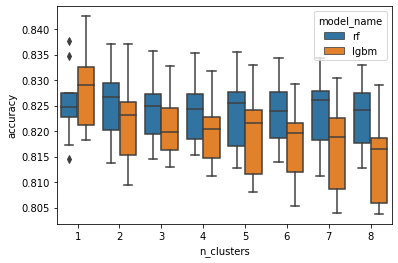

In [11]:
sns.boxplot(data=results, x='n_clusters', y='accuracy', hue='model_name')

<AxesSubplot: xlabel='n_clusters', ylabel='f1_score'>

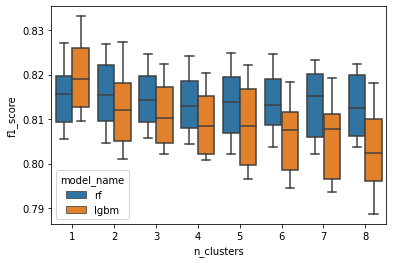

In [12]:
sns.boxplot(data=results, x='n_clusters', y='f1_score', hue='model_name')

<AxesSubplot: xlabel='n_clusters', ylabel='training_time'>

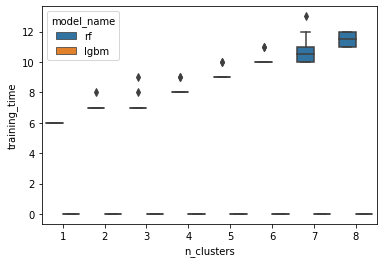

In [13]:
sns.boxplot(data=results, x='n_clusters', y='training_time', hue='model_name')